# Imports

In [1]:
!pip install cltk inltk sentencepiece transformers indic-nlp-library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 845 kB 6.7 MB/s 
     |████████████████████████████████| 1.3 MB 8.3 MB/s 
     |████████████████████████████████| 5.8 MB 36.0 MB/s 
     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 33.8 MB 166 kB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
     |████████████████████████████████| 691 kB 40.6 MB/s 
     |████████████████████████████████| 182 kB 43.9 MB/s 
     |████████████████████████████████| 193 kB 40.5 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 240 kB 65.3 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 233 kB 42.0 MB/s 
     |████████████████████████████████| 355 kB 58.7 MB/s 
     |████████████████████████████████| 1

In [2]:
import six
import sys
import re
import os
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import nltk
from nltk.tag import tnt
from nltk.corpus import indian
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from indicnlp.tokenize.sentence_tokenize import sentence_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline 
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import warnings
warnings.filterwarnings('ignore')
from inltk.inltk import tokenize, remove_foreign_languages, setup
from functools import partial
from transformers import AutoModel, AutoTokenizer


from google.colab import drive,files
drive.mount('/content/gdrive')

# Google collab dir: Account: kikarand@iu.edu
DATA_DIR = "gdrive/MyDrive/data/"
# setup('hi')


Mounted at /content/gdrive


In [3]:
sentence_split_partial = partial(sentence_split,lang="hi")
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')
tokenize_partial = partial(tokenize, language_code="hi")
remove_foreign_languages_partial = partial(remove_foreign_languages, language_code="hi")
nltk.download('all')
train_data = indian.tagged_sents('hindi.pos')
tnt_pos_tagger = tnt.TnT()
tnt_pos_tagger.train(train_data)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'sop_classifier.classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nlt

In [4]:
URL_CSV = DATA_DIR + "hindi_data_csv.csv"

## Reading an SMS text dataset into pandas

In [5]:
with open(URL_CSV, "r") as fp:
    sms = pd.read_csv(fp)

## Exploratory Data Analysis

In [6]:
# examine the shape
sms.shape


(5572, 2)

In [7]:
# examine the first 10 rows
sms.head(10)

,Message,Label
0,"जुरोंग पॉइंट तक जाएं, पागल.. केवल बुगिस एन ग्र...",ham
1,ओके लार... यू ओनी के साथ मजाक कर रहा हूं...,ham
2,21 मई 2005 को एफए कप फाइनल टीके जीतने के लिए स...,spam
3,यू डुन ने इतनी जल्दी हॉर कहा... यू सी पहले से ...,ham
4,"नहीं, मुझे नहीं लगता कि वह यूएसएफ जाता है, हाल...",ham
5,FreeMsg हेलो डार्लिंग अब 3 सप्ताह हो गए हैं और...,spam
6,मेरा भाई भी मुझसे बात करना पसंद नहीं करता। वे ...,ham
7,आपके अनुरोध के अनुसार 'Melle Melle (Oru Minnam...,ham
8,विजेता!! एक महत्वपूर्ण नेटवर्क ग्राहक के रूप म...,spam
9,क्या आपका मोबाइल 11 महीने या उससे अधिक का था? ...,spam


In [18]:
sms.describe(include='all')

,Message,Label,label_num
count,5572,5572,5572.000000
unique,5162,2,NaN
top,माफ करना मैं बाद में बात करता हूँ,ham,NaN
freq,30,4825,NaN
mean,NaN,NaN,0.134063
std,NaN,NaN,0.340751
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


In [8]:
# examine the class distribution
sms.Label.value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [9]:
# convert label to a numerical variable
sms['label_num'] = sms.Label.map({'ham':0, 'spam':1})

In [10]:
# check that the conversion worked
sms.head(10)

,Message,Label,label_num
0,"जुरोंग पॉइंट तक जाएं, पागल.. केवल बुगिस एन ग्र...",ham,0
1,ओके लार... यू ओनी के साथ मजाक कर रहा हूं...,ham,0
2,21 मई 2005 को एफए कप फाइनल टीके जीतने के लिए स...,spam,1
3,यू डुन ने इतनी जल्दी हॉर कहा... यू सी पहले से ...,ham,0
4,"नहीं, मुझे नहीं लगता कि वह यूएसएफ जाता है, हाल...",ham,0
5,FreeMsg हेलो डार्लिंग अब 3 सप्ताह हो गए हैं और...,spam,1
6,मेरा भाई भी मुझसे बात करना पसंद नहीं करता। वे ...,ham,0
7,आपके अनुरोध के अनुसार 'Melle Melle (Oru Minnam...,ham,0
8,विजेता!! एक महत्वपूर्ण नेटवर्क ग्राहक के रूप म...,spam,1
9,क्या आपका मोबाइल 11 महीने या उससे अधिक का था? ...,spam,1


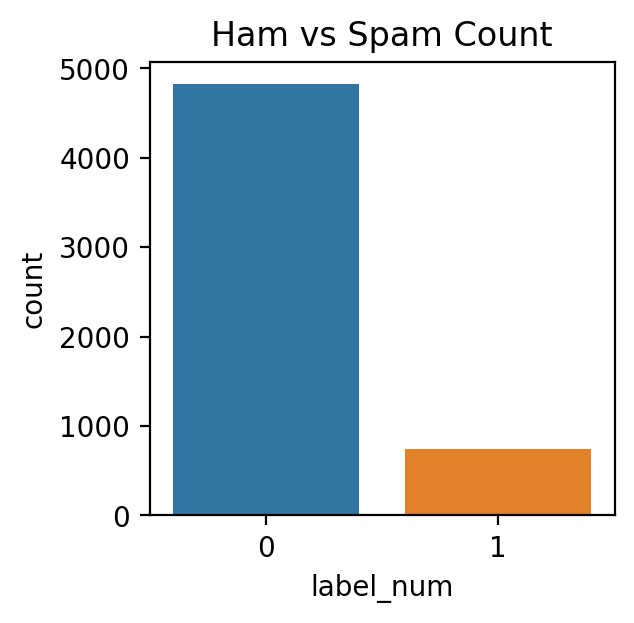

In [15]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.set_title("Ham vs Spam Count")
sns.countplot(sms['label_num'], ax=ax)

## Train, Valid, Test dataset selection

In [20]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X, y = sms[["Message"]], sms.label_num.to_numpy().ravel()
print(X.shape)
print(y.shape)

# split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35,random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.35, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.35, random_state=42)

print("-------------------------------------------------")
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"Y train           shape: {y_train.shape}")
print(f"Y validation      shape: {y_valid.shape}")
print(f"Y test            shape: {y_test.shape}")

(5572, 1)
(5572,)
-------------------------------------------------
X train           shape: (1529, 1)
X validation      shape: (1268, 1)
X test            shape: (824, 1)
Y train           shape: (1529,)
Y validation      shape: (1268,)
Y test            shape: (824,)


## Pipeline

### Auxiliary classes and Variables

In [21]:
stop_words_hindi = set([
  'अंदर','अत','अदि','अप','अपना','अपनि','अपनी','अपने','अभि','अभी','आदि','आप','इंहिं',
  'इंहें','इंहों','इतयादि','इत्यादि','इन','इनका','इन्हीं','इन्हें','इन्हों','इस','इसका','इसकि',
  'इसकी','इसके','इसमें','इसि','इसी','इसे','उंहिं','उंहें','उंहों','उन','उनका','उनकि','उनकी',
  'उनके','उनको','उन्हीं','उन्हें','उन्हों','उस','उसके','उसि','उसी','उसे','एक','एवं','एस',
  'एसे','ऐसे','ओर','और','कइ','कई','कर','करता','करते','करना','करने','करें','कहते',
  'कहा','का','काफि','काफ़ी','कि','किंहें','किंहों','कितना','किन्हें','किन्हों','किया','किर','किस',
  'किसि','किसी','किसे','की','कुछ','कुल','के','को','कोइ','कोई','कोन','कोनसा','कौन',
  'कौनसा','गया','घर','जब','जहाँ','जहां','जा','जिंहें','जिंहों','जितना','जिधर','जिन','जिन्हें',
  'जिन्हों','जिस','जिसे','जीधर','जेसा','जेसे','जैसा','जैसे','जो','तक','तब','तरह','तिंहें',
  'तिंहों','तिन','तिन्हें','तिन्हों','तिस','तिसे','तो','था','थि','थी','थे','दबारा','दवारा','दिया',
  'दुसरा','दुसरे','दूसरे','दो','द्वारा','न','नहिं','नहीं','ना','निचे','निहायत','नीचे','ने','पर',
  'पहले','पुरा','पूरा','पे','फिर','बनि','बनी','बहि','बही','बहुत','बाद','बाला','बिलकुल',
  'भि','भितर','भी','भीतर','मगर','मानो','मे','में','यदि','यह','यहाँ','यहां','यहि','यही',
  'या','यिह','ये','रखें','रवासा','रहा','रहे','ऱ्वासा','लिए','लिये','लेकिन','व','वगेरह','वरग',
  'वर्ग','वह','वहाँ','वहां','वहिं','वहीं','वाले','वुह','वे','वग़ैरह','संग','सकता','सकते','सबसे',
  'सभि','सभी','साथ','साबुत','साभ','सारा','से','सो','हि','ही','हुअ','हुआ','हुइ','हुई',
  'हुए','हे','हें','है','हैं','हो','होता','होति','होती','होते','होना','होने'])




In [22]:
class CleanMessages(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): 
        
        self.stop_words_regex = "|".join(stop_words_hindi)
        return pd.DataFrame(X.Message.apply(self.clean_messages))

   
    def clean_messages(self, text):
        text=re.sub(r'(\d+)',r'',text)
        text=re.sub("\<.*\>",'',text)
        text=re.sub("[\=|\<|\>|\;|\_|\å|\Õ|\Ì|\Ï|\Ò|\Ó|\Ó|\Û|\ª|\Ï]",'',text)
        text=re.sub("[a-zA-Z0-9]*",'',text)
        text=re.sub(self.stop_words_regex,'',text)
        text=text.replace(r',','')
        text=text.replace(r'"','')
        text=text.replace(r'(','')
        text=text.replace(r')','')
        text=text.replace(r'"','')
        text=text.replace(r':','')
        text=text.replace(r"'",'')
        text=text.replace(r"‘‘",'')
        text=text.replace(r"’’",'')
        text=text.replace(r"''",'')
        text=text.replace(r".",'')
        return text


class MessageStemma(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return pd.DataFrame(X.Message.apply(self.generate_stemma))


    def generate_stemma(self, text):
        suffixes = {
            1: [u"ो",u"े",u"ू",u"ु",u"ी",u"ि",u"ा"],
            2: [u"कर",u"ाओ",u"िए",u"ाई",u"ाए",u"ने",u"नी",u"ना",u"ते",u"ीं",u"ती",u"ता",u"ाँ",u"ां",u"ों",u"ें"],
            3: [u"ाकर",u"ाइए",u"ाईं",u"ाया",u"ेगी",u"ेगा",u"ोगी",u"ोगे",u"ाने",u"ाना",u"ाते",u"ाती",u"ाता",u"तीं",u"ाओं",u"ाएं",u"ुओं",u"ुएं",u"ुआं"],
            4: [u"ाएगी",u"ाएगा",u"ाओगी",u"ाओगे",u"एंगी",u"ेंगी",u"एंगे",u"ेंगे",u"ूंगी",u"ूंगा",u"ातीं",u"नाओं",u"नाएं",u"ताओं",u"ताएं",u"ियाँ",u"ियों",u"ियां"],
            5: [u"ाएंगी",u"ाएंगे",u"ाऊंगी",u"ाऊंगा",u"ाइयाँ",u"ाइयों",u"ाइयां"],
        } #suffixes in hindi language that change tense, gender, number but not the meaning

        stems=list()
        for word in sentence_split_partial(text):
            if word not in stop_words_hindi:
                for L in range(1,5): 
                    if len(word) >= L + 1:
                        for suffix in suffixes[L]:
                            if word.endswith(suffix):
                                word=word[:-L] #stripping the suffix from the word
            if word:
                stems.append(word)
        return " ".join(stems)

class Toeknizer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return pd.DataFrame(X.Message.apply(self.tokenizer))


    def tokenizer(self, text): return tokenizer.decode(tokenizer(text, padding=True)["input_ids"])


class PosHindi(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return pd.DataFrame(X.Message.apply(self.genearte_and_concatenate_pos))


    def genearte_and_concatenate_pos(self, text): 
        tagged_words = tnt_pos_tagger.tag(nltk.word_tokenize(text))
        return text + " ".join(map(lambda x:x[1], tagged_words)) 


class Bypassed(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return X

class Estimatorstub(object):   
    """
    # Class to for proxy estimator.
    """
    
    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return self


class FeatureSelectionstub(object):   
    """
    # Class to for proxy Feature Selector.
    """
    
    def fit(self, X, y=None): return self
    
    def transform(self, X, y=None): return self


class ColumnSelector(BaseEstimator):
    def __init__(self, cols=None, drop_axis=False):
        self.cols = cols
        self.drop_axis = drop_axis

    def fit_transform(self, X, y=None): return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        # We use the loc or iloc accessor if the input is a pandas dataframe
        if hasattr(X, "loc") or hasattr(X, "iloc"):
            if type(self.cols) == tuple:
                self.cols = list(self.cols)
            types = {type(i) for i in self.cols}
            if len(types) > 1:
                raise ValueError(
                    "Elements in `cols` should be all of the same data type."
                )
            if isinstance(self.cols[0], int):
                t = X.iloc[:, self.cols].values
            elif isinstance(self.cols[0], str):
                t = X.loc[:, self.cols].values
            else:
                raise ValueError("Elements in `cols` should be either `int` or `str`.")
        else:
            t = X[:, self.cols]

        if t.shape[-1] == 1 and self.drop_axis:
            t = t.reshape(-1)
        if len(t.shape) == 1 and not self.drop_axis:
            t = t[:, np.newaxis]
        return t

    def fit(self, X, y=None):        return 

In [23]:
full_pipeline_with_predictor = Pipeline([
        ('preprocessing', CleanMessages()),
        ("feature_selection_1", FeatureSelectionstub()),
        ("feature_selection_2", FeatureSelectionstub()),
        ("feature_selection_3", FeatureSelectionstub()),
        ('col_selector', ColumnSelector(cols=('Message'),drop_axis=True)),
        ("vectorizer", FeatureSelectionstub()),
        ("clf", Estimatorstub()),
    ])

param_grid = [
    {
        "feature_selection_1": (MessageStemma(),),
        "feature_selection_2": (Toeknizer(),),
        "feature_selection_3": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False),),
        "vectorizer__norm": ["l1", "l2"],        
        'clf': (BernoulliNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    },   
    {
        "feature_selection_1": (Bypassed(),),
        "feature_selection_2": (Toeknizer(),),
        "feature_selection_3": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False),),
        'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
        "vectorizer__norm": ["l1", "l2"],        
        'clf': (BernoulliNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    }, 
    {
    "feature_selection_1": (Bypassed(),),
    "feature_selection_2": (Toeknizer(),),
    "feature_selection_3": (Bypassed(),),
    "vectorizer": (TfidfVectorizer(lowercase=False,norm="l2"),),
    'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
    "vectorizer__norm": ["l1", "l2"],        
    'clf': (BernoulliNB(),),
    "clf__alpha": [0.25, 0.5, 0.75, 1]
    }, 
    {
    "feature_selection_1": (Bypassed(),),
    "feature_selection_2": (Bypassed(),),
    "feature_selection_3": (PosHindi(),),
    "vectorizer": (TfidfVectorizer(lowercase=False,norm="l2"),),
    'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
    'clf': (BernoulliNB(alpha=0.5),),
    }, 
    {
        "feature_selection_1": (MessageStemma(),),
        "feature_selection_2": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False),),
        "vectorizer__norm": ["l1", "l2"],        
        'clf': (BernoulliNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    }, 
    {
        "feature_selection_1": (Toeknizer(),),
        "feature_selection_2": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False),),
        "vectorizer__norm": ["l1", "l2"],        
        'clf': (BernoulliNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    },
    {
        "feature_selection_1": (Bypassed(),),
        "feature_selection_2": (Bypassed(),),
        "feature_selection_3": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False,norm="l2"),),
        'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
        'clf': (MultinomialNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    },  
    {
        "feature_selection_1": (MessageStemma(),),
        "feature_selection_2": (Toeknizer(),),
        "feature_selection_3": (PosHindi(),),
        "vectorizer": (TfidfVectorizer(lowercase=False,norm="l2"),),
        'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
        'clf': (MultinomialNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    },  
    {
        "feature_selection_1": (MessageStemma(),),
        "feature_selection_2": (Toeknizer(),),
        "feature_selection_3": (PosHindi(),),
        "vectorizer": (CountVectorizer(lowercase=False),),
        'col_selector': (ColumnSelector(cols=('Message'),drop_axis=True),),
        'clf': (MultinomialNB(),),
        "clf__alpha": [0.25, 0.5, 0.75, 1]
    },  
]
# RandomizedSearchCV
gsv = GridSearchCV(
    full_pipeline_with_predictor, param_grid, 
    cv=3, n_jobs=-1, verbose=2, return_train_score=True, scoring="roc_auc"
)
model = gsv.fit(X_train,y_train)

print("The best roc_auc_score is: {}".format(model.best_score_))
print("------ The best parameters are: {}".format(model.best_params_))
print("The accuracy score of this model is:{}".format(np.round(accuracy_score(y_train, model.predict(X_train)), 3)))
print("\n\nGrid search Results:-----")
display(pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score"))
print("The accuracy score of this model is:{}".format(np.round(accuracy_score(y_test, model.predict(X_test)), 3)))



expLog_columns = ["exp_name","Train Acc", "Valid Acc","Test  Acc","Train AUC", "Valid AUC","Test AUC"]
exp_name = f"Gridserach_stpes_{len(model.best_estimator_.steps)}_{'|'.join(_[1].__str__() for _ in model.best_estimator_.steps)}"

try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=expLog_columns)


expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 

display(expLog)

print("\n\n-----Historical Experiment Results......")
### Stroing the logs to file storage in case of kernel failure....
historical_logs = os.path.join(DATA_DIR, "cla_expLog.csv")
if os.path.exists(historical_logs):
    old_explog = pd.read_csv(historical_logs)
    df = pd.concat([old_explog, expLog])
    df.drop_duplicates(inplace=True)
    df.to_csv(historical_logs, index=False)
else:
    expLog.to_csv(historical_logs, index=False)
    
display(pd.read_csv(historical_logs).sort_values(by="Test AUC")) 


Fitting 3 folds for each of 53 candidates, totalling 159 fits
The best roc_auc_score is: 0.9907914271344161
------ The best parameters are: {'clf': BernoulliNB(alpha=0.25), 'clf__alpha': 0.25, 'col_selector': ColumnSelector(cols='Message', drop_axis=True), 'feature_selection_1': Bypassed(), 'feature_selection_2': Toeknizer(), 'feature_selection_3': Bypassed(), 'vectorizer': TfidfVectorizer(lowercase=False, norm='l1'), 'vectorizer__norm': 'l1'}
The accuracy score of this model is:0.993


Grid search Results:-----


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__alpha,param_feature_selection_1,param_feature_selection_2,param_feature_selection_3,param_vectorizer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
17,0.473886,0.024765,0.240192,0.019820,BernoulliNB(alpha=0.25),0.25,Bypassed(),Toeknizer(),Bypassed(),"TfidfVectorizer(lowercase=False, norm='l1')",...,0.987878,0.994057,0.990791,0.002535,1,0.999484,0.998611,0.999088,0.999061,0.000357
16,1.565006,0.744961,0.224043,0.009776,BernoulliNB(alpha=0.25),0.25,Bypassed(),Toeknizer(),Bypassed(),"TfidfVectorizer(lowercase=False, norm='l1')",...,0.987878,0.994057,0.990791,0.002535,1,0.999484,0.998611,0.999088,0.999061,0.000357
8,3.931795,1.731864,1.328313,0.489018,BernoulliNB(),0.25,Bypassed(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.988999,0.994120,0.990128,0.002911,3,0.999417,0.998603,0.998853,0.998958,0.000340
0,3.233437,1.140021,1.055322,0.036278,BernoulliNB(),0.25,MessageStemma(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.989140,0.994152,0.990121,0.002973,4,0.999434,0.998635,0.998945,0.999005,0.000329
1,1.775824,0.183339,0.925571,0.161634,BernoulliNB(),0.25,MessageStemma(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.989140,0.994152,0.990121,0.002973,4,0.999434,0.998635,0.998845,0.998971,0.000338
9,2.256223,0.747546,1.069183,0.439014,BernoulliNB(),0.25,Bypassed(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.988579,0.994184,0.990073,0.002943,6,0.999467,0.998643,0.998904,0.999005,0.000344
18,1.520920,0.720712,0.242003,0.019165,BernoulliNB(alpha=0.25),0.5,Bypassed(),Toeknizer(),Bypassed(),"TfidfVectorizer(lowercase=False, norm='l1')",...,0.986022,0.993802,0.989820,0.003179,7,0.997868,0.996631,0.997054,0.997184,0.000513
19,0.469804,0.026844,0.239635,0.017884,BernoulliNB(alpha=0.25),0.5,Bypassed(),Toeknizer(),Bypassed(),"TfidfVectorizer(lowercase=False, norm='l1')",...,0.985881,0.993834,0.989806,0.003248,8,0.997868,0.996591,0.997054,0.997171,0.000528
2,2.762034,0.859886,1.102170,0.055571,BernoulliNB(),0.5,MessageStemma(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.986267,0.993993,0.989591,0.003245,9,0.997777,0.996695,0.996870,0.997114,0.000474
11,1.803925,0.187763,0.888769,0.190654,BernoulliNB(),0.5,Bypassed(),Toeknizer(),PosHindi(),TfidfVectorizer(lowercase=False),...,0.986267,0.993961,0.989538,0.003245,10,0.997843,0.996735,0.996920,0.997166,0.000485


The accuracy score of this model is:0.958


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9928,0.9724,0.9575,0.9991,0.9778,0.9681




-----Historical Experiment Results......


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
11,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.8646,0.8644,0.8629,0.5000,0.5000,0.5000
7,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9169,0.9059,0.8987,0.9570,0.9335,0.9009
6,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9520,0.9601,0.9418,0.9627,0.9471,0.9278
12,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9935,0.9708,0.9575,0.9990,0.9625,0.9518
13,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9928,0.9724,0.9575,0.9991,0.9778,0.9680
14,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9928,0.9724,0.9575,0.9991,0.9778,0.9681
0,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9742,0.9729,0.9550,0.9895,0.9884,0.9838
1,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9742,0.9729,0.9550,0.9895,0.9884,0.9838
9,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9629,0.9553,0.9400,0.9905,0.9767,0.9860
8,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9629,0.9553,0.9400,0.9905,0.9767,0.9861


In [ ]:
import os
expLog_columns = ["exp_name","Train Acc", "Valid Acc","Test  Acc","Train AUC", "Valid AUC","Test AUC"]
exp_name = f"Gridserach_stpes_{len(model.best_estimator_.steps)}_{'|'.join(_[1].__str__() for _ in model.best_estimator_.steps)}"

try:
    expLog = pd.DataFrame(columns=expLog_columns)
except NameError:
    expLog = pd.DataFrame(columns=expLog_columns)


expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 

display(expLog)

print("\n\n-----Historical Experiment Results......")
### Stroing the logs to file storage in case of kernel failure....
historical_logs = os.path.join(DATA_DIR, "cla_expLog.csv")
if os.path.exists(historical_logs):
    old_explog = pd.read_csv(historical_logs)
    df = pd.concat([old_explog, expLog])
    df.drop_duplicates(inplace=True)
    df.to_csv(historical_logs, index=False)
else:
    expLog.to_csv(historical_logs, index=False)
    
display(pd.read_csv(historical_logs).sort_values(by="Test AUC")) 


In [24]:
print("\n\n-----Historical Experiment Results......")
### Stroing the logs to file storage in case of kernel failure....
historical_logs = os.path.join(DATA_DIR, "cla_expLog.csv")
display(pd.read_csv(historical_logs).sort_values(by="Test AUC")) 



-----Historical Experiment Results......


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
11,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.8646,0.8644,0.8629,0.5000,0.5000,0.5000
7,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9169,0.9059,0.8987,0.9570,0.9335,0.9009
6,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9520,0.9601,0.9418,0.9627,0.9471,0.9278
12,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9935,0.9708,0.9575,0.9990,0.9625,0.9518
13,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9928,0.9724,0.9575,0.9991,0.9778,0.9680
14,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9928,0.9724,0.9575,0.9991,0.9778,0.9681
0,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9742,0.9729,0.9550,0.9895,0.9884,0.9838
1,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9742,0.9729,0.9550,0.9895,0.9884,0.9838
9,Gridserach_stpes_7_CleanMessages()|MessageStem...,0.9629,0.9553,0.9400,0.9905,0.9767,0.9860
8,Gridserach_stpes_7_CleanMessages()|Bypassed()|...,0.9629,0.9553,0.9400,0.9905,0.9767,0.9861



True Positives: 87
False Positives: 9
True Negatives: 702
False Negatives: 26
True Positive Rate: 0.7699115044247787
Specificity: 0.9873417721518988
False Positive Rate: 0.012658227848101266


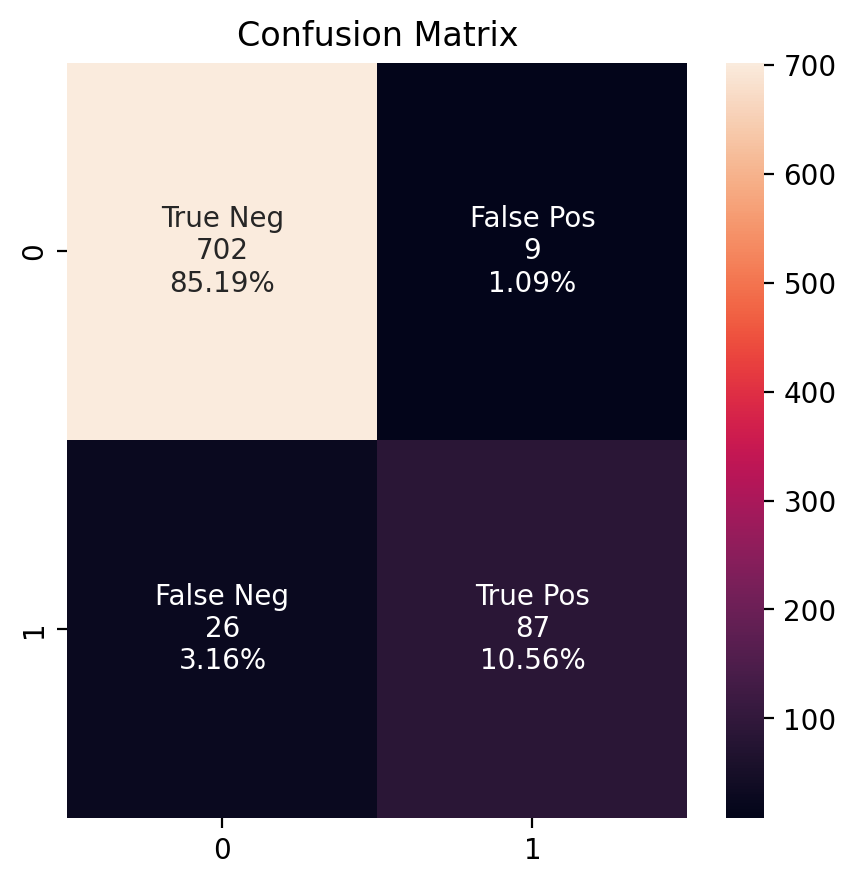

In [52]:
cf_matrix = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=200)
ax.set_title("Confusion Matrix")
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", ax=ax)

tn, fp, fn, tp = cf_matrix.ravel()

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')


### Saving model

In [53]:
import joblib
  
# Save the trained model as a pickle string.
file_name = DATA_DIR +'finalized_model.sav'

joblib.dump(model, file_name)


# load the model from disk
loaded_model = joblib.load(file_name)
result = loaded_model.score(X_test, y_test)
print(result)
  

0.9681179443137548


In [56]:
%%shell
jupyter nbconvert --to html gdrive/MyDrive/data/spam_classifier_hindi.ipynb

[NbConvertApp] Converting notebook gdrive/MyDrive/data/spam_classifier_hindi.ipynb to html
/usr/local/lib/python3.8/dist-packages/nbconvert/filters/datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 503828 bytes to gdrive/MyDrive/data/spam_classifier_hindi.html
